In [ ]:
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import os
import tensorflow as tf

In [ ]:
# Hyperparameters
batch_size = 64
num_classes = 10
epochs = 300
l = 6
num_filter = 35
compression = 1.0

In [ ]:
# Load CIFAR10 Data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]

# convert to one hot encoing 
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes) 

170500096/170498071 [==============================] - 11s 0us/step


In [ ]:
datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.125,
            height_shift_range=0.125,
            horizontal_flip=True,
            fill_mode='nearest',
            zoom_range=0.10)

In [ ]:
X_train.shape

(50000, 32, 32, 3)

In [ ]:
X_test.shape

(10000, 32, 32, 3)

In [ ]:
# Dense Block
def denseblock(input, num_filter = 12):
    global compression
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_3_3 = layers.Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

## transition Blosck
def transition(input, num_filter = 12):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

#output layer
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
    Out_conv = layers.Conv2D(filters=num_classes,kernel_size = 2,strides = 1, use_bias=False ,padding='valid',
              activation='softmax',name='Out_conv')(AvgPooling)

    output = layers.Flatten()(Out_conv)
    return output

In [ ]:
input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

Block_1 = denseblock(First_Conv2D, num_filter)
Transition_1 = transition(Block_1, num_filter)

Block_2 = denseblock(Transition_1, num_filter)
Transition_2 = transition(Block_2, num_filter)

Block_3 = denseblock(Transition_2, num_filter)
Transition_3 = transition(Block_3, num_filter)

Last_Block = denseblock(Transition_3,  num_filter)
output = output_layer(Last_Block)

In [ ]:
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 35)   945         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 35)   140         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 35)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
class stop_training_905(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(stop_training_905, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        val_acc = logs["val_accuracy"]
        if val_acc >= self.threshold:
            self.model.stop_training = True

In [ ]:
def decay_learn(epoch, lr):
    if epoch < 50:
        return 0.001
    elif epoch >= 50 and epoch < 75:
        return 0.0001
    else:
        return 0.00001

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(decay_learn)

In [ ]:
checkpoint = ModelCheckpoint("recent_model.hdf5", monitor='loss', verbose=1,
    save_weights_only=False, mode='auto', save_freq='epoch')

In [ ]:
training_till_905 = stop_training_905(threshold=0.905)

In [ ]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(), metrics=['accuracy'])

In [ ]:
datagen.fit(X_train)
history_1 = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),epochs=epochs,
                       verbose=1, validation_data=(X_test, y_test),
                       callbacks=[training_till_905,checkpoint,lr_scheduler])

Epoch 1/300
782/782 [==============================] - ETA: 0s - loss: 1.4719 - accuracy: 0.4652
Epoch 00001: saving model to recent_model.hdf5
782/782 [==============================] - 53s 68ms/step - loss: 1.4719 - accuracy: 0.4652 - val_loss: 2.2943 - val_accuracy: 0.3995 - lr: 0.0010
Epoch 2/300
782/782 [==============================] - ETA: 0s - loss: 1.0381 - accuracy: 0.6305
Epoch 00002: saving model to recent_model.hdf5
782/782 [==============================] - 52s 66ms/step - loss: 1.0381 - accuracy: 0.6305 - val_loss: 1.0546 - val_accuracy: 0.6484 - lr: 0.0010
Epoch 3/300
782/782 [==============================] - ETA: 0s - loss: 0.8604 - accuracy: 0.6969
Epoch 00003: saving model to recent_model.hdf5
782/782 [==============================] - 51s 66ms/step - loss: 0.8604 - accuracy: 0.6969 - val_loss: 1.4157 - val_accuracy: 0.5941 - lr: 0.0010
Epoch 4/300
782/782 [==============================] - ETA: 0s - loss: 0.7483 - accuracy: 0.7365
Epoch 00004: saving model to rece

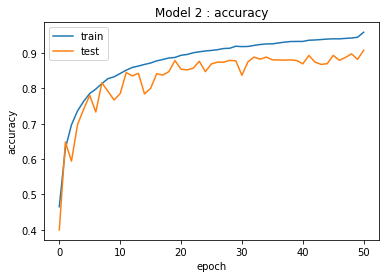

In [ ]:
#plotting 
import matplotlib.pyplot as plt
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model 2 : accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Test the model
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 3s 9ms/step - loss: 0.2997 - accuracy: 0.9080
Test loss: 0.2997393012046814
Test accuracy: 0.9079999923706055
